In [12]:
import json
with open('user-wallet-transactions.json', 'r') as f:
    data = json.load(f)

asset_symbols = [
    entry["actionData"]["assetSymbol"]
    for entry in data
    if "actionData" in entry and "assetSymbol" in entry["actionData"]
]

unique_symbols = set(asset_symbols)

print("Total unique assetSymbol types:", len(unique_symbols))
print("Unique assetSymbols:", unique_symbols)

Total unique assetSymbol types: 9
Unique assetSymbols: {'WMATIC', '', 'AAVE', 'USDC', 'WPOL', 'DAI', 'USDT', 'WBTC', 'WETH'}


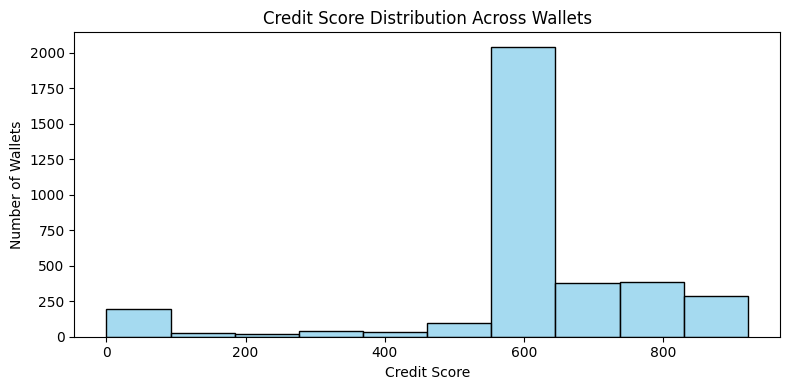

In [13]:
import json
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Token precision (how many decimals each token uses)
TOKEN_PRECISION = {
    'USDT': 1e6,
    'USDC': 1e6,
    'DAI': 1e18,
    'WETH': 1e18,
    'WBTC': 1e8,
    'AAVE': 1e18,
    'WMATIC': 1e18,
    'WPOL': 1e18,
    '': 1e18
}

with open('user-wallet-transactions.json', 'r') as f:
    transactions = json.load(f)

# Aggregate features per wallet
wallets = defaultdict(lambda: {
    'deposit_usd': 0,
    'borrow_usd': 0,
    'repay_usd': 0,
    'liquidations': 0,
    'tx_count': 0,
    'timestamps': []
})

# Process each transaction
for tx in transactions:
    wallet = tx['userWallet']
    action = tx['action'].lower()
    data = tx['actionData']

    symbol = data.get('assetSymbol', '')
    price = float(data.get('assetPriceUSD', 0))
    amount_raw = float(data.get('amount', 0))
    precision = TOKEN_PRECISION.get(symbol, 1e18)
    usd_value = (amount_raw / precision) * price

    if action == 'deposit':
        wallets[wallet]['deposit_usd'] += usd_value
    elif action == 'borrow':
        wallets[wallet]['borrow_usd'] += usd_value
    elif action == 'repay':
        wallets[wallet]['repay_usd'] += usd_value
    elif action == 'redeemunderlying':
        wallets[wallet]['deposit_usd'] -= usd_value
    elif action == 'liquidationcall':
        wallets[wallet]['liquidations'] += 1

    wallets[wallet]['tx_count'] += 1
    wallets[wallet]['timestamps'].append(tx['timestamp'])

# Define the credit scoring logic
def compute_score(w):
    deposit = w['deposit_usd']
    borrow = w['borrow_usd']
    repay = w['repay_usd']
    liquidations = w['liquidations']
    tx_count = w['tx_count']
    duration = max(w['timestamps']) - min(w['timestamps']) if len(w['timestamps']) > 1 else 0

    borrow_ratio = borrow / deposit if deposit > 0 else 0
    repay_ratio = repay / borrow if borrow > 0 else 0

    score = 600
    score += 100 * min(repay_ratio, 1.2)
    score -= 150 * borrow_ratio
    score -= 200 * liquidations
    score += 10 * min(tx_count, 20)
    score += duration / (60 * 60 * 24 * 30)

    return max(0, min(1000, int(score)))

# Calculate scores
wallet_scores = []
for wallet, data in wallets.items():
    score = compute_score(data)
    wallet_scores.append({
        'wallet': wallet,
        'deposit_usd': round(data['deposit_usd'], 2),
        'borrow_usd': round(data['borrow_usd'], 2),
        'repay_usd': round(data['repay_usd'], 2),
        'liquidations': data['liquidations'],
        'tx_count': data['tx_count'],
        'score': score
    })

# Save result to JSON
with open('wallet_scores.json', 'w') as f:
    json.dump(wallet_scores, f, indent=2)

# Plot score distribution
df = pd.DataFrame(wallet_scores)
plt.figure(figsize=(8, 4))
sns.histplot(df['score'], bins=10, color='skyblue', edgecolor='black')
plt.title("Credit Score Distribution Across Wallets")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.tight_layout()
plt.savefig("score_distribution.png")
plt.show()

In [14]:
import pandas as pd

df = pd.read_json('wallet_scores.json')
bins = [0,100,200,300,400,500,600,700,800,900,1000]
counts = pd.cut(df['score'], bins=bins).value_counts().sort_index()
print(counts)

score
(0, 100]         12
(100, 200]       29
(200, 300]       22
(300, 400]       40
(400, 500]       54
(500, 600]      251
(600, 700]     2124
(700, 800]      411
(800, 900]      262
(900, 1000]     109
Name: count, dtype: int64
